## Image Similarity
Detecting similar images, e.g. for recognizing same person or duplicated images.

<table class="tfo-notebook-buttons" align="left"><td>
        <a target="_blank"  href="https://colab.research.google.com/github/dzlab/deepprojects/blob/master/classification/CV_Image_Similarity_with_Keras.ipynb">
            <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
        </td><td>
        <a target="_blank"  href="https://github.com/dzlab/deepprojects/blob/master/classification/CV_Image_Similarity_with_Keras.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import numpy as np
import pathlib
import glob
import urllib.request
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [5]:
print(tf.VERSION)
print(tf.keras.__version__)

1.12.0
2.1.6-tf


In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Data
Will be using the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) which has 37 categories of dogs and cats, with 200 images for each class.

In [8]:
!curl -O http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  8902k      0  0:01:26  0:01:26 --:--:-- 9543k


In [0]:
!tar xzf images.tar.gz

In [0]:
path = pathlib.Path('images')

Create a generate for those images

In [0]:
class ImageGenerator(Sequence):
    """Generator for a sequence of Images"""
    def __init__(self, path, fnames, classes, batch_size, image_size=(224, 224), shuffle=True):
        self.path = path
        self.image_size, self.batch_size = image_size, batch_size
        self.items = fnames
        self.items_size = len(fnames)
        self.classes, self.classes_size = classes, len(classes)
        self.indexes = np.arange(self.items_size)
        self.shuffle= shuffle
        self.on_epoch_end()
        
    def get_label_name_from_fname(self, fname):
        """Get the name of the image label from the filename"""
        return '_'.join(fname.split('_')[:-1]).lower()
    
    def get_label_index_from_fname(self, fname):
        """Get the index of the label from the filename"""
        lbl_name = self.get_label_name_from_fname(fname)
        return self.classes.index(lbl_name)

    def load_urls_(self, indexes):
        """Load the urls of the images into a tensor"""
        # init target arrays
        images = np.zeros((self.batch_size, self.image_size[0], self.image_size[1], 3), dtype=np.float32)
        labels = np.zeros((self.batch_size, self.classes_size), dtype=np.float32)
        # Find list of urls in this batch
        urls = [self.path/self.items[k] for k in indexes]
        lbls = [self.get_label_index_from_fname(self.items[k]) for k in indexes]
        for index, img_path in enumerate(urls):
            # read image from url
            img = preprocessing.image.load_img(img_path, target_size=self.image_size)
            img_data = preprocessing.image.img_to_array(img)
            # read the proper label
            lbl_data = np.zeros((self.classes_size), dtype=np.float32)
            lbl_data[lbls[index]]=1
            # append data
            images[index, :] = img_data
            labels[index, :] = lbl_data
            
        return images, labels
        
    def on_epoch_end(self):
        """Rearrange the indexes after each epoch"""
        self.indexes = np.arange(self.items_size)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __len__(self):
        """Number of batches per epoch"""
        return int(np.floor(self.items_size / self.batch_size))
    
    def __getitem__(self, index):
        """Generate one batch of data"""
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data for the batch
        X, y = self.load_urls_(indexes)
        return X, y

A helper class for dealing with image data

In [0]:
def ceildiv(a, b):
    return -(-a // b)

def plots_from_files(imspaths, figsize=(10,5), rows=1, titles=None, maintitle=None):
    """Plot the images in a grid"""
    f = plt.figure(figsize=figsize)
    if maintitle is not None: plt.suptitle(maintitle, fontsize=16)
    for i in range(len(imspaths)):
        sp = f.add_subplot(rows, ceildiv(len(imspaths), rows), i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        img = plt.imread(imspaths[i])
        plt.imshow(img)

class DataBunch():
    """An image data bunch"""
    def __init__(self, path, pattern='*.jpg', valid_pct=0.2, batch_size=62, image_size=(224, 224)):
        self.classes = []
        train_fnames, valid_fnames = [], []
        for p in path.glob(pattern):
            label = '_'.join(p.stem.split('_')[:-1]).lower()
            if label not in self.classes:
                self.classes.append(label)
            if np.random.uniform() > valid_pct:
                train_fnames.append(p.name)
            else:
                valid_fnames.append(p.name)
        self.classes.sort()
        self.train_gen = ImageGenerator(path, train_fnames, self.classes, batch_size)
        self.valid_gen = ImageGenerator(path, valid_fnames, self.classes, batch_size)
        
    def show_bunch(self, rows=3, figsize=(7, 6), **kwargs):
        """Show a bunch of images from the dataset"""
        imspaths = self.train_gen.items[0:9]
        titles = ['_'.join(p.split('_')[:-1]).lower() for p in imspaths]
        imspaths = [(path/p).as_posix() for p in imspaths]
        plots_from_files(imspaths, figsize, rows, titles)

    @property
    def c(self):
        return self.classes

In [0]:
data = DataBunch(path)

In [14]:
print(len(data.c), data.c)

37 ['abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'bengal', 'birman', 'bombay', 'boxer', 'british_shorthair', 'chihuahua', 'egyptian_mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'maine_coon', 'miniature_pinscher', 'newfoundland', 'persian', 'pomeranian', 'pug', 'ragdoll', 'russian_blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'siamese', 'sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


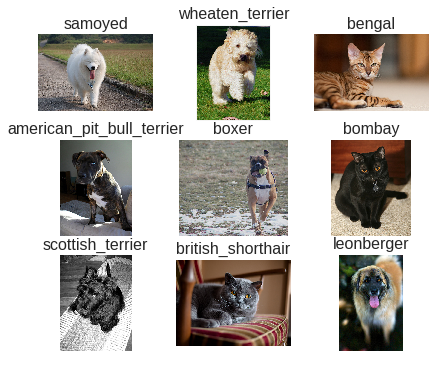

In [15]:
data.show_bunch()

## Learner

In [0]:
class Learner():
    def __init__(self):
        pass
            
    # freeze all layers of the model (from left to right)
    @classmethod
    def freeze(cls, model, limit=None):
        # handle negative indices
        if limit != None and limit < -1:
            limit = limit + len(model.layers) 
        # loop for all valid indices and mark the corresponding layer
        for index, layer in enumerate(model.layers):
            if limit != None and index > limit:
                break
            layer.trainable = False

    # unfreeze all layers of the model up to the given layer index (from right to left)
    @classmethod
    def unfreeze(cls, model, limit=None):
        # handle negative indices
        if limit != None and limit < -1:
            limit = limit + len(model.layers)
        for index, layer in enumerate(model.layers):
            if limit != None and index < limit:
                continue
            layer.trainable = True
    
class ImageClassificationLearner(Learner):
    def __init__(self, data, archi, loss='categorical_crossentropy', metrics=['accuracy']):
        self.data = data
        self.model = self._create_model(archi)
        # compile the model to before training
        adam = Adam(lr=0.001, epsilon=0.01, decay=0.0001)
        self.model.compile(adam, loss, metrics)
        

    def _create_model(self, archi):
        model1 = ResNet50(weights='imagenet')
        # 1. freeze the original model up to the last layer we will keep
        Learner.freeze(model1, -3)
        # 2. create a new model that will be chained to the output of our base model
        x = model1.layers[-3].output          # shape should be (bs=None, 7, 7, 2048)
        x = Dropout(rate=0.3)(x)              # shape should be (bs=None, 7, 7, 2048)
        x = GlobalAveragePooling2D()(x)       # shape should be (bs=None, 2048)
        x = Dense(1024, activation='relu')(x) # shape should be (bs=None, 1024)
        x = BatchNormalization()(x)
        y = Dense(len(self.data.c), activation='softmax')(x) # shape should be (bs=None, num_champti
        model2 = Model(inputs=model1.input, outputs=y)
        return model2
        
    def fit(self, epochs=5):
        # fit the model using the previous generators
        train_gen = self.data.train_gen
        valid_gen = self.data.valid_gen
        history = self.model.fit_generator(generator=train_gen, validation_data=valid_gen, epochs=epochs, use_multiprocessing=True)
        return history


In [17]:
learner = ImageClassificationLearner(data, archi='resnet50')

102858752/102853048 [==============================] - 9s 0us/step


In [18]:
history = learner.fit()

Epoch 1/5
94/94 [==============================] - 71s 757ms/step - loss: 1.8676 - acc: 0.5024 - val_loss: 1.1500 - val_acc: 0.6438
Epoch 2/5
94/94 [==============================] - 64s 677ms/step - loss: 0.5089 - acc: 0.8445 - val_loss: 0.9133 - val_acc: 0.7036
Epoch 3/5
94/94 [==============================] - 64s 684ms/step - loss: 0.2697 - acc: 0.9327 - val_loss: 0.8810 - val_acc: 0.7245
Epoch 4/5
94/94 [==============================] - 65s 687ms/step - loss: 0.1663 - acc: 0.9652 - val_loss: 0.8419 - val_acc: 0.7406
Epoch 5/5
94/94 [==============================] - 64s 685ms/step - loss: 0.1128 - acc: 0.9835 - val_loss: 0.8669 - val_acc: 0.7520


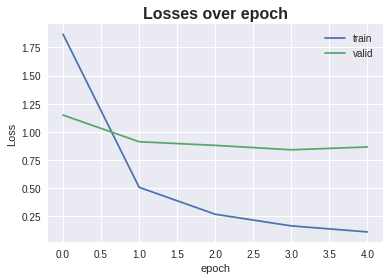

In [19]:
plt.plot(history.history['loss'], label="train")
plt.plot(history.history['val_loss'], label="valid")

# Add legend
plt.legend(loc='top left')
# Add title and x, y labels
plt.title("Losses over epoch", fontsize=16, fontweight='bold')
#plt.suptitle("Random Walk Suptitle", fontsize=10)
plt.xlabel("epoch")
plt.ylabel("Loss")

plt.show()

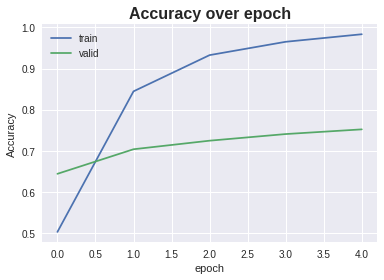

In [20]:
plt.plot(history.history['acc'], label="train")
plt.plot(history.history['val_acc'], label="valid")

# Add legend
plt.legend(loc='top left')
# Add title and x, y labels
plt.title("Accuracy over epoch", fontsize=16, fontweight='bold')
#plt.suptitle("Random Walk Suptitle", fontsize=10)
plt.xlabel("epoch")
plt.ylabel("Accuracy")

plt.show()

## Similarity
Let's calculate the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) between a subset of images. E.g. take two images from each pet class and calculate similarities using the output of the activations.

In [0]:
class ImageItem():
    def __init__(self, x):
        self.image_size = image_size

    
    def from_url(img_path, image_size=(224, 224)):
        img = preprocessing.image.load_img(img_path, target_size=image_size)
        img_data = preprocessing.image.img_to_array(img)
        x = np.expand_dims(img_data, axis=0)
        x = preprocess_input(x)
        return img, img_data, x
    
    def from_urls(imgpaths, image_size=(224, 224)):
        X = []
        for index, img_path in enumerate(imgpaths):
            img, img_data, x = ImageItem.from_url(img_path, image_size)
            X.append(x[0])
        return X

In [0]:
classes = data.c

In [26]:
images_by_cls = {}
for p in path.glob('*.jpg'):
    clss = '_'.join(p.stem.split('_')[:-1]).lower()
    if clss not in images_by_cls:
        images_by_cls[clss] = [p]
    elif len(images_by_cls[clss])==1:
        images_by_cls[clss].append(p)
        
imgpaths = []
for clss in images_by_cls:
    for elm in images_by_cls[clss]:
        imgpaths.append(elm)

print(imgpaths)

[PosixPath('images/samoyed_173.jpg'), PosixPath('images/samoyed_116.jpg'), PosixPath('images/Russian_Blue_89.jpg'), PosixPath('images/Russian_Blue_186.jpg'), PosixPath('images/wheaten_terrier_91.jpg'), PosixPath('images/wheaten_terrier_127.jpg'), PosixPath('images/Bengal_60.jpg'), PosixPath('images/Bengal_100.jpg'), PosixPath('images/american_pit_bull_terrier_43.jpg'), PosixPath('images/american_pit_bull_terrier_57.jpg'), PosixPath('images/boxer_56.jpg'), PosixPath('images/boxer_77.jpg'), PosixPath('images/Bombay_163.jpg'), PosixPath('images/Bombay_154.jpg'), PosixPath('images/Birman_47.jpg'), PosixPath('images/Birman_30.jpg'), PosixPath('images/scottish_terrier_141.jpg'), PosixPath('images/scottish_terrier_113.jpg'), PosixPath('images/British_Shorthair_106.jpg'), PosixPath('images/British_Shorthair_79.jpg'), PosixPath('images/leonberger_117.jpg'), PosixPath('images/leonberger_20.jpg'), PosixPath('images/german_shorthaired_124.jpg'), PosixPath('images/german_shorthaired_167.jpg'), Posi

for image claculate the value its activations generated by the model

In [72]:
model = learner.model
target_layer_index = len(model.layers) - 6 # activation_48
print(model.layers[target_layer_index].name, model.layers[0].input_shape, model.layers[target_layer_index].output_shape)
activations_fct = K.function([model.layers[0].input], [model.layers[target_layer_index].output])

activation_48 (None, 224, 224, 3) (None, 7, 7, 2048)


In [71]:
batch = ImageItem.from_urls(imgpaths)
print(len(batch), batch[0].shape, model.layers[0].input_shape, isinstance(batch, (list, tuple)))
activations = activations_fct(batch)

print(batch.shape, len(activations))

74 (224, 224, 3) (None, 224, 224, 3) True


InvalidArgumentError: ignored

In [73]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

TensorShape([Dimension(None), Dimension(224), Dimension(224), Dimension(3)])